In [1]:
# Google.colab drive integration
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# specify the desired data location to the current working directory
%cd /content/drive/MyDrive/Dataset

/content/drive/.shortcut-targets-by-id/1hQJhZXCBbc369GWFH06FCrflHQ8EO2xS/Dataset


In [3]:
# Keras prepocessing library
! pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00


In [4]:
# Get the required Library
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [5]:
# Training Data Path and Image gen (Normalization)
TRAINING_DIR = "/content/drive/MyDrive/Dataset/DatasetV2/Dataset/Split_300/Training"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Validation Data Path and Image gen (Normalization)
VALIDATION_DIR = "/content/drive/MyDrive/Dataset/DatasetV2/Dataset/Split_300/Validation"
validation_datagen = ImageDataGenerator(rescale = 1./255)

# Training gen and batching
train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

# Validation gen and batching
validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

Found 3120 images belonging to 13 classes.
Found 780 images belonging to 13 classes.


In [6]:
# Just making sure the library to import things from G Drive Is present
from google.colab import drive
import os # Library to manipulate OS  I.E Copying, changing, and or reading things on folders

directoryTrain = '/content/drive/MyDrive/Dataset/DatasetV2/Dataset/Training' # Change directory depending on your file's path
directoryVal = '/content/drive/MyDrive/Dataset/DatasetV2/Dataset/Validation'

# List the contents of the directory
# Code to Check wether there is file's in the directory or not (Might be useful to debug)
try:
    files = os.listdir(directoryTrain)
    print("Files in directory:", files)
except FileNotFoundError:
    print(f"The directory {directoryTrain} does not exist.")

try:
    files = os.listdir(directoryVal)
    print("Files in directory:", files)
except FileNotFoundError:
    print(f"The directory {directoryVal} does not exist.")

Files in directory: ['Academic_Art', 'Art_Nouveau', 'Baroque', 'Expressionism', 'Japanese_Art', 'Neoclassicism', 'Primitivism', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Abstract']
Files in directory: ['Academic_Art', 'Art_Nouveau', 'Baroque', 'Expressionism', 'Japanese_Art', 'Neoclassicism', 'Primitivism', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Abstract']


#Model

In [8]:
def get_defined_label(x):
    label_dict = {'Abstract': 0, 'Academic_Art': 1, 'Art_Nouveau': 2, 'Baroque': 3, 'Expressionism': 4, 'Japanese_Art': 5, 'Neoclassicism': 6,
                  'Primitivism': 7, 'Realism': 8, 'Renaissance': 9, 'Rococo': 10, 'Romanticism': 11, 'Symbolism': 12}
    for key, value in label_dict:
        if key == x:
            return value

In [9]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

base_model = InceptionResNetV2(
        input_shape=(224,224,3),
        weights='imagenet',
        include_top=False,
        pooling='avg'
    )
base_model.trainable = False

219055592/219055592 [==============================] - 3s 0us/step


In [10]:
print('Base Model Ouput Shape = {}'.format(base_model.output_shape))
last_output = base_model.output

Base Model Ouput Shape = (None, 1536)


In [11]:
x = tf.keras.layers.Dropout(0.2)(last_output)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=13, activation='softmax')(x)

In [12]:
# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [13]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0002, momentum=0.9, centered=True),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [14]:
# Define callbacks
learning_rate_reduction = [
    ReduceLROnPlateau(
        monitor='val_accuracy',
        patience=1,
        verbose=1,
        factor=0.25,
        min_lr=0.000003),
    EarlyStopping(
        monitor='val_loss',
        min_delta=0.001,
        patience=5,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=True)
]

In [15]:
# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=learning_rate_reduction
)

Epoch 1/30
98/98 [==============================] - 2095s 21s/step - loss: 2.2990 - accuracy: 0.2388 - val_loss: 1.9348 - val_accuracy: 0.3308 - lr: 2.0000e-04
Epoch 2/30
98/98 [==============================] - 160s 2s/step - loss: 1.9362 - accuracy: 0.3340 - val_loss: 1.8166 - val_accuracy: 0.4051 - lr: 2.0000e-04
Epoch 3/30
98/98 [==============================] - 153s 2s/step - loss: 1.7673 - accuracy: 0.4205 - val_loss: 1.5950 - val_accuracy: 0.4782 - lr: 2.0000e-04
Epoch 4/30
98/98 [==============================] - ETA: 0s - loss: 1.6602 - accuracy: 0.4471
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
98/98 [==============================] - 150s 2s/step - loss: 1.6602 - accuracy: 0.4471 - val_loss: 1.6163 - val_accuracy: 0.4679 - lr: 2.0000e-04
Epoch 5/30
98/98 [==============================] - 152s 2s/step - loss: 1.5245 - accuracy: 0.4875 - val_loss: 1.4771 - val_accuracy: 0.5256 - lr: 5.0000e-05
Epoch 6/30
98/98 [==============================]

#Save Model

In [16]:
# Save the model
model.save('model6_ArtNaon.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# You can also use this cell as a shortcut for downloading your model
from google.colab import files
files.download("model6_ArtNaon.h5")

#Grafik

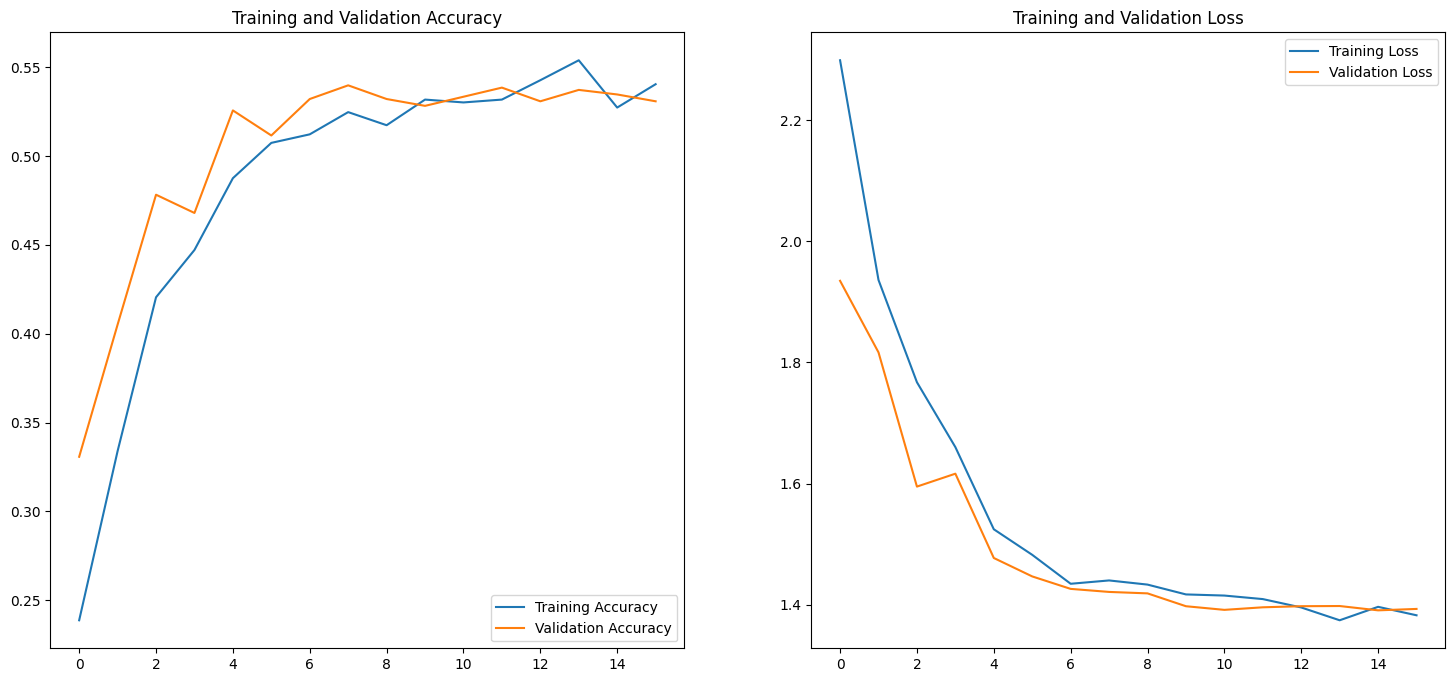

In [20]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = len(acc)  # Automatically set the number of epochs to the length of the accuracy array
epochs_range = range(epochs)

plt.figure(figsize=(18, 8))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#Training

1/1 [==============================] - 4s 4s/step


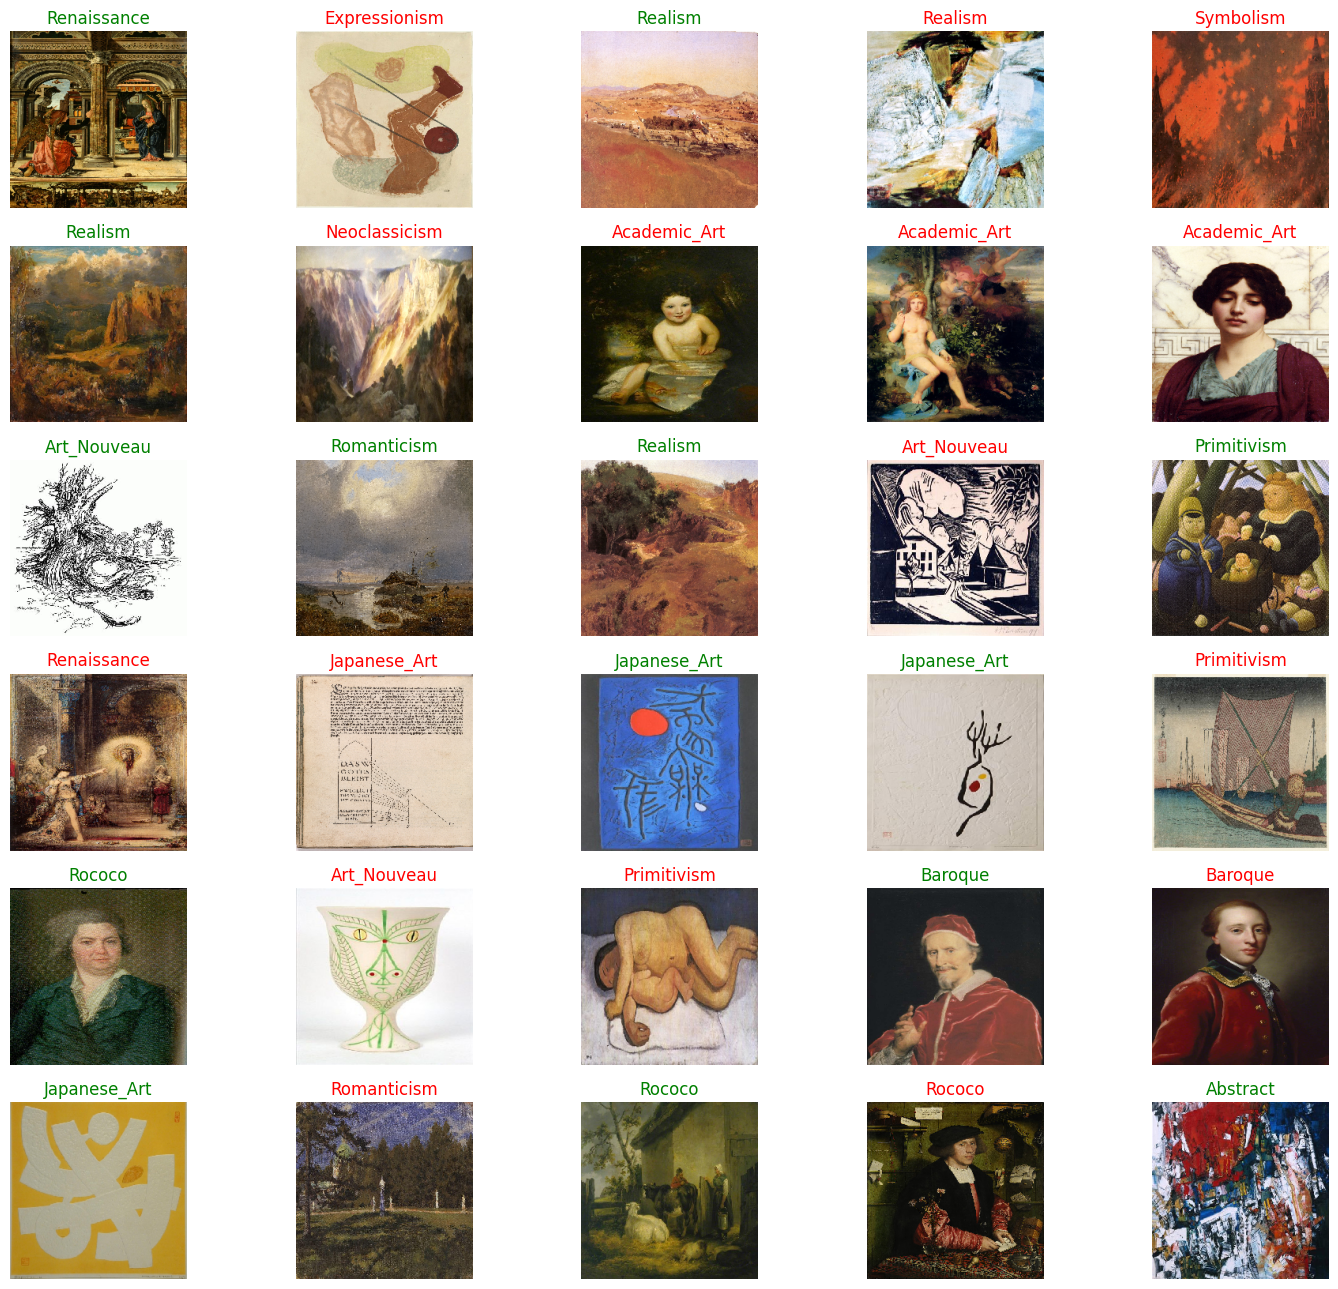

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/Model/model6_ArtNaon.h5')

# Assuming validation_generator is already set up and is part of the code that was provided
# Make sure to use the correct directory for the validation data
# validation_generator = ...

# Get a batch of images from the validation generator
img, labels = next(validation_generator)

# Define the class indices (mapping) as obtained previously
class_indices = {'Abstract': 0, 'Academic_Art': 1, 'Art_Nouveau': 2, 'Baroque': 3, 'Expressionism': 4, 'Japanese_Art': 5, 'Neoclassicism': 6,
                 'Primitivism': 7, 'Realism': 8, 'Renaissance': 9, 'Rococo': 10, 'Romanticism': 11, 'Symbolism': 12}
# Reverse the class indices dictionary to map indices to class names for display
indices_class = {v: k for k, v in class_indices.items()}

# Predict the class of each image in the batch
predictions = model.predict(img)

# Set up the figure for plotting images
plt.figure(figsize=(15, 13))

# Plot each image in the batch
for i in range(30):  # Assuming you want to plot 30 images
    ax = plt.subplot(6, 5, i + 1)  # Adjust the number of rows and cols accordingly
    plt.imshow(img[i])

    # Get the predicted and true labels
    predicted_label = indices_class[np.argmax(predictions[i])]
    true_label = indices_class[np.argmax(labels[i])]

    # Set the title of each plot to the predicted label
    # If the prediction is correct, the title is set in green; otherwise, it's set in red
    title_color = 'green' if predicted_label == true_label else 'red'
    plt.title(predicted_label, color=title_color)
    plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#Image Classification

In [33]:
#with model 6
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  #Upload image
  path = fn
  img = load_img(path, target_size=(224, 224))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  #Predict image
  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  print(fn)
  print(classes)

Saving 314733.jpg to 314733.jpg
1/1 [==============================] - 0s 58ms/step
314733.jpg
[[9.6352884e-34 0.0000000e+00 0.0000000e+00 0.0000000e+00 7.5799480e-35
  2.8991094e-11 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]]


In [34]:
classes[0]

array([9.6352884e-34, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       7.5799480e-35, 2.8991094e-11, 0.0000000e+00, 1.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00], dtype=float32)

In [35]:
np.argmax(classes[0])

7

In [7]:
class_indices = train_generator.class_indices
print(class_indices)

{'Abstract': 0, 'Academic_Art': 1, 'Art_Nouveau': 2, 'Baroque': 3, 'Expressionism': 4, 'Japanese_Art': 5, 'Neoclassicism': 6, 'Primitivism': 7, 'Realism': 8, 'Renaissance': 9, 'Rococo': 10, 'Romanticism': 11, 'Symbolism': 12}


In [2]:
plt.imshow(img)
if(np.argmax(classes[0])) == 0:
  print("Abstract art is an art form that does not attempt to accurately depict visual reality, but instead uses shapes, colors, and gestural strokes to achieve its effect. In the abstract art genre, artists focus on these visual elements to express emotions, concepts, or ideas without necessarily referring to real objects or specific scenes.")
elif(np.argmax(classes[0])) == 1:
  print("Academic art, also known as academicism or academism, refers to a style of painting and sculpture shaped by the influence of European art academies. This genre specifically encompasses art and artists guided by the standards of the French Académie des Beaux-Arts, encompassing the Neoclassicism and Romanticism movements, as well as the art that aimed to synthesize both styles. This synthesis is best exemplified by the works of William-Adolphe Bouguereau, Thomas Couture, and Hans Makart. In this context, it is often referred to as academism, art pompier, and eclecticism, and is sometimes associated with historicism and syncretism. Academic art is closely linked to Beaux-Arts architecture, which emerged from the same environment and adheres to similar classicizing principles.")
elif(np.argmax(classes[0])) == 2:
  print("Art Nouveau is an ornamental style of art that flourished between about 1890 and 1910 throughout Europe and the United States. Art Nouveau is characterized by its use of a long, sinuous, organic line and was often employed in architecture, interior design, jewelry and glass design, posters, and illustration.")
elif(np.argmax(classes[0])) == 3:
  print("The term Baroque, derived from the Portuguese ‘barocco’ meaning ‘irregular pearl or stone’, refers to a cultural and art movement that characterized Europe from the early seventeenth to mid-eighteenth century. Baroque emphasizes dramatic, exaggerated motion and clear, easily interpreted, detail. Due to its exuberant irregularities, Baroque art has often been defined as bizarre or uneven.")
elif(np.argmax(classes[0])) == 4:
  prin("Expressionism is an artistic style in which the artist seeks to depict not objective reality but rather the subjective emotions and responses that objects and events arouse within a person. The artist accomplishes this aim through distortion, exaggeration, primitivism, and fantasy and through the vivid, jarring, violent, or dynamic application of formal elements.")
elif(np.argmax(classes[0])) == 5:
  print("Japanese art is the painting, calligraphy, architecture, pottery, sculpture, and other visual arts produced in Japan from about 10,000 BCE to the present. Within its diverse body of expression, certain characteristic elements seem to be recurrent: adaptation of other cultures, respect for nature as a model, humanization of religious iconography, and appreciation for material as a vehicle of meaning.")
elif(np.argmax(classes[0])) == 6:
  print("Neoclassical art, a widespread and influential movement in painting and the other visual arts that began in the 1760s reached its height in the 1780s and ’90s and lasted until the 1840s and ’50s. Neoclassicism in the arts is an aesthetic attitude based on the art of Greece and Rome in antiquity, which invokes harmony, clarity, restraint, universality, and idealism.")
elif(np.argmax(classes[0])) == 7:
  print("In Western art, Primitivism is an aesthetic idealization aimed at recreating the experience of primitive times, places, and people through emulation or re-creation. In Western philosophy, Primitivism suggests that primitive societies have superior morals and ethics compared to urbanized civilizations. European Primitivist art incorporates techniques, motifs, and styles from Asian, African, and Australasian arts, which were considered primitive relative to Western urban civilization.")
elif(np.argmax(classes[0])) == 8:
  print("Realism, in the arts, the accurate, detailed, unembellished depiction of nature or of contemporary life. Realism rejects imaginative idealization in favor of a close observation of outward appearances. Originating in Europe during the mid-19th century as a reaction against bourgeois art norms, it marked the advent of modern art.")
elif(np.argmax(classes[0])) == 9:
  print("Renaissance art, painting, sculpture, architecture, music, and literature produced during the 14th, 15th, and 16th centuries in Europe under the combined influences of an increased awareness of nature, a revival of classical learning, and a more individualistic view of man. The cornerstone of Renaissance art was Classical antiquity, considered to be the most noble of all historical traditions.")
elif(np.argmax(classes[0])) == 10:
  print("Rococo art, considered a more delicate version of Baroque style, is closely associated with the aristocracy. Its paintings typically portray aristocrats engaged in leisurely activities such as courtship rituals and picnics in idyllic natural settings. The figures are depicted as tall, slender, elegant, and graceful, often adorned in lavish attire. The paintings often feature serene natural environments with lush foliage and statues, contributing to a sense of harmony and tranquility. Colors are soft and pastel, with occasional bursts of pink roses. Despite its contemporary connection to literary satire, Rococo art exudes an air of happiness and carefree enjoyment, with themes often revolving around love and romance.")
elif(np.argmax(classes[0])) == 11:
  print("Romanticism, attitude or intellectual orientation that characterized many works of literature, painting, music, architecture, criticism, and historiography in Western civilization over a period from the late 18th to the mid-19th century. Romanticism can be seen as a rejection of the precepts of order, calm, harmony, balance, idealization, and rationality that typified Classicism in general and late 18th-century Neoclassicism in particular.")
else:
  print("Symbolism was a loosely structured literary and artistic movement that emerged from French poets in the late 19th century and extended to painting and theater, impacting European and American literature in the 20th century. Symbolist artists aimed to convey personal emotional experiences through intricate and suggestive symbolism in their work.")

NameError: name 'img' is not defined